In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
import os
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
db_path = os.path.join(os.getcwd(), "Resources", "hawaii.sqlite")
engine = create_engine(f"sqlite:///{db_path}")

In [21]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)


In [22]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
recent= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent.date

'2017-08-23'

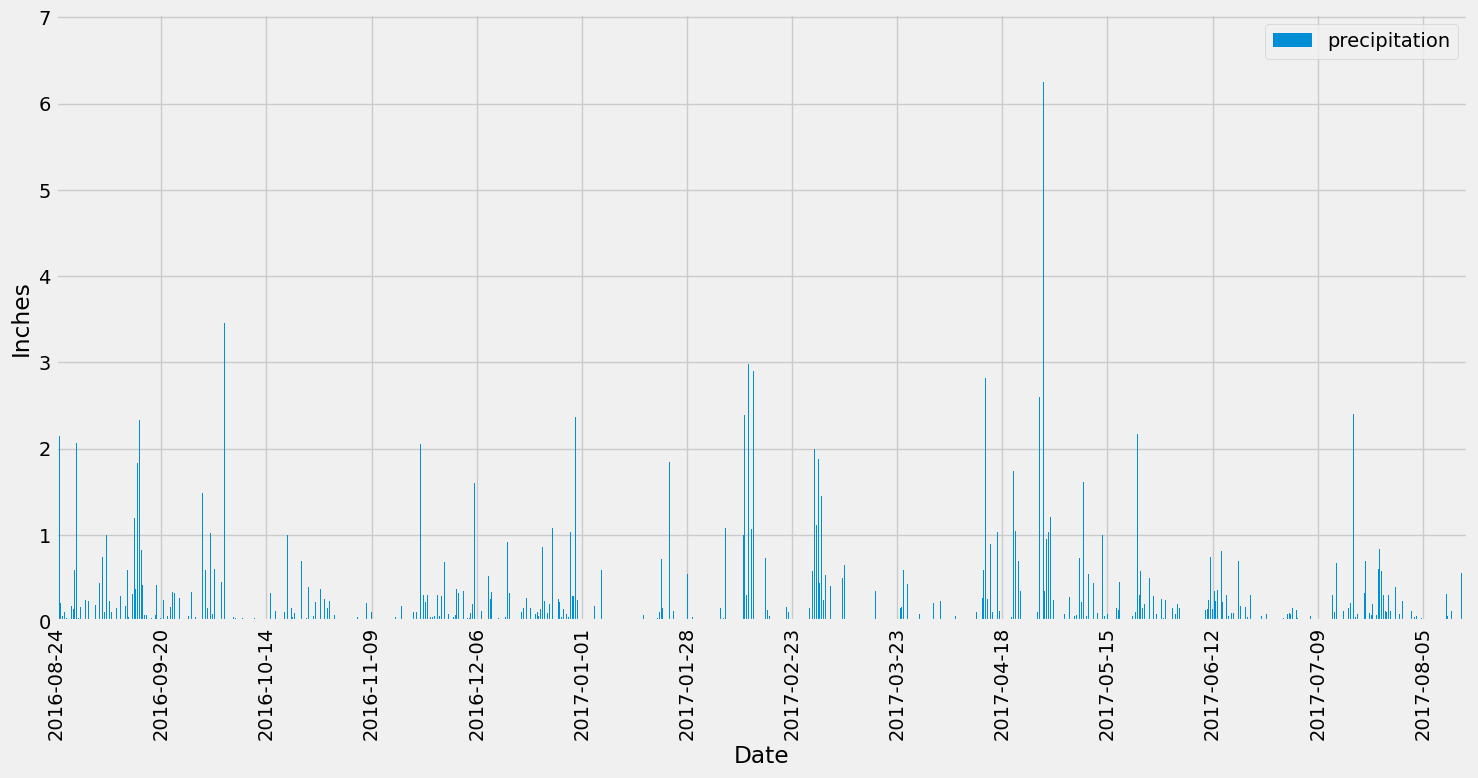

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_data_point = dt.datetime.strptime(recent.date,"%Y-%m-%d")
    
# Calculate the date one year from the last date in data set.
year_data = recent_data_point - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(
        Measurement.date, Measurement.prcp
    ).filter(
        sqlalchemy.and_(
            Measurement.date >= year_data,
            Measurement.prcp >= 0
        )
    ).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data,columns=[
    'Dates',
    'precipitation'
])
# Sort the dataframe by date
sorted_df = df.sort_values(by=['Dates']).set_index(
    'Dates'
)
# Use Pandas Plotting with Matplotlib to plot the data
graph = sorted_df.plot(kind="bar",figsize=(15,8), xlabel="Date", ylabel="Inches")
xticklabels = sorted_df.index
xtickindex = np.arange(len(sorted_df.index))
graph.set_xticks(xtickindex[::150],xticklabels[::150],rotation=90)
plt.tight_layout()
plt.show()

In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
session.query(
    Measurement.station
).distinct().count()

9

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
        Measurement.station, 
        func.count(Measurement.prcp).label('count')
    ).group_by(
        Measurement.station
    ).order_by(
        func.count(Measurement.prcp).desc()
    )
most_active_stations.all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = most_active_stations.first()
result = session.query(
    func.min(Measurement.tobs).label("min_tobs"),
    func.max(Measurement.tobs).label('max_tobs'),
    func.avg(Measurement.tobs).label("avg_tobs")
).filter(
    Measurement.station == active_station.station
).all()
result

[(54.0, 85.0, 71.66378066378067)]

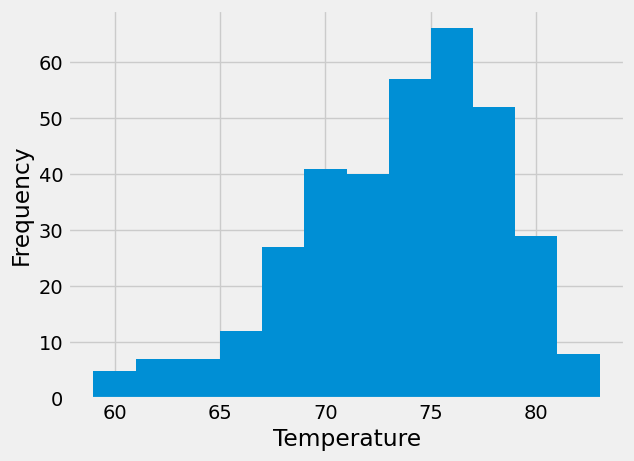

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(
        Measurement.tobs
    ).filter(
        sqlalchemy.and_(
            Measurement.date >= year_data,
            Measurement.station == active_station.station
        )
    ).all()
df = pd.DataFrame(temp, columns=['Temperature'])
plt.hist(df['Temperature'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [32]:
# Close Session
session.close()